In [46]:
import pandas as pd
import numpy as np
from random import seed, randint
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score

In [2]:
def display_scroll(df):
    pd.set_option("display.max_rows", None)
    display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" +
                 df.style.to_html() +
                 "</div>"))
    pd.set_option("display.max_rows", 20)

In [3]:
# light_train is built and saved by 'reduce_memory_usage' pipeline
train = catalog.load("light_train")
train.set_index('index', inplace=True)
display(train.head())

[04/15/23 16:39:52] INFO     Loading data from 'light_train' (PickleDataSet)...                 ]8;id=901286;file:///Users/iferreiro/miniconda3/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=579287;file:///Users/iferreiro/miniconda3/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

,session_id,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,level_group
index,,,,,,,,,,,,,,,,
0,20090312431273200,0,cutscene_click,basic,0,NaN,-414.0,-159.375,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0-4
1,20090312431273200,1323,person_click,basic,0,NaN,-414.0,-159.375,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
2,20090312431273200,831,person_click,basic,0,NaN,-414.0,-159.375,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
3,20090312431273200,1147,person_click,basic,0,NaN,-414.0,-159.375,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
4,20090312431273200,1863,person_click,basic,0,NaN,-413.0,-159.375,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4


In [66]:
labels = catalog.load("train_labels")
# labels.set_index('index', inplace=True)
display(labels.head())

[04/16/23 19:59:03] INFO     Loading data from 'train_labels' (CSVDataSet)...                   ]8;id=614798;file:///Users/iferreiro/miniconda3/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=843003;file:///Users/iferreiro/miniconda3/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090312455206810_q1,1
3,20090313091715820_q1,0
4,20090313571836404_q1,1


In [5]:
# List the different questions
l = labels['session_id'].str.split('_', expand=True).groupby(1)[0].nunique()
display(l)

1
q1     23562
q10    23562
q11    23562
q12    23562
q13    23562
q14    23562
q15    23562
q16    23562
q17    23562
q18    23562
q2     23562
q3     23562
q4     23562
q5     23562
q6     23562
q7     23562
q8     23562
q9     23562
Name: 0, dtype: int64

# Baseline model for question 1
## Feature engineering

In [6]:
labels_q1 = labels[labels['session_id'].str[-3:] == '_q1']
labels_q1.loc[:,'session_id'] = labels_q1['session_id'].str.split('_', expand=True)[0].astype(int)
display(labels_q1.head())

,session_id,correct
0,20090312431273200,1
1,20090312433251036,0
2,20090312455206810,1
3,20090313091715820,0
4,20090313571836404,1


In [7]:
train_q1 = train[train['level_group'] == '0-4']
features_q1 = pd.pivot_table(train_q1, index = 'session_id', columns = 'level', values = 'elapsed_time', aggfunc = max)
for level in features_q1.columns[1:]:
    features_q1[level] = features_q1[level] - features_q1[level-1]
display(features_q1)

level,0,1,2,3,4
session_id,,,,,
20090312431273200,25766,39693,61020,94734,100126
20090312433251036,13148,41063,104844,80879,152873
20090312455206810,10947,240257,43416,277844,85382
20090313091715820,16837,33019,43343,86666,106127
20090313571836404,37065,29967,84648,68883,126968
...,...,...,...,...,...
22100215342220508,80445,126138,202403,253028,301607
22100215460321130,58153,59420,148127,120741,235058
22100217104993650,62161,52494,110581,243188,166471


In [17]:
data_q1 = features_q1.merge(labels_q1, left_on = 'session_id', right_on = 'session_id')
data_q1.columns = data_q1.columns.astype(str)
display(data_q1.head())

,session_id,0,1,2,3,4,correct
0,20090312431273200,25766,39693,61020,94734,100126,1
1,20090312433251036,13148,41063,104844,80879,152873,0
2,20090312455206810,10947,240257,43416,277844,85382,1
3,20090313091715820,16837,33019,43343,86666,106127,0
4,20090313571836404,37065,29967,84648,68883,126968,1


## Feature EDA

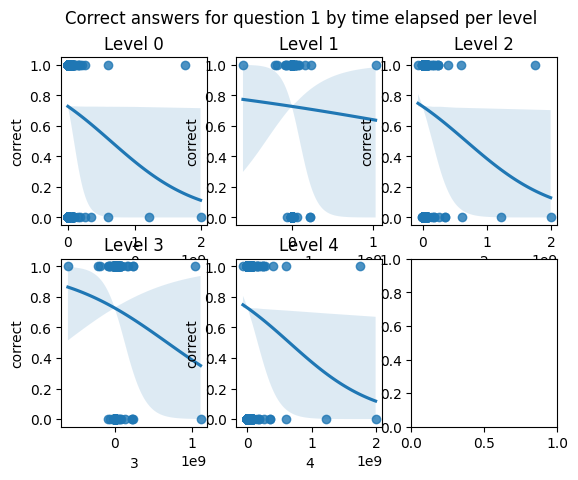

In [18]:
fig, axes = plt.subplots(2, 3)
fig.suptitle('Correct answers for question 1 by time elapsed per level')

for level in range(0,5):
    active_ax = axes[level//3,level%3]
    active_ax.set_title('Level '+str(level))
    sns.regplot(data = data_q1, ax=active_ax, x=str(level), y='correct',
                logistic = True)
    
plt.show()

## Preprocessing

In [23]:
X = data_q1.drop(['session_id', 'correct'], axis = 1).to_numpy()
y = data_q1['correct'].to_numpy()
display(X, y)

array([[ 25766,  39693,  61020,  94734, 100126],
       [ 13148,  41063, 104844,  80879, 152873],
       [ 10947, 240257,  43416, 277844,  85382],
       ...,
       [ 62161,  52494, 110581, 243188, 166471],
       [ 54097,  25364,  83213,  58627, 133100],
       [ 74808,  52009, 187884, 155088, 279967]], dtype=int32)

array([1, 0, 1, ..., 1, 0, 0])

In [25]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
display(scaled_X)

array([[-0.02685681, -0.0064124 , -0.03175132, -0.01730521, -0.03710186],
       [-0.02747373, -0.00625315, -0.02965502, -0.01849024, -0.03460471],
       [-0.02758134,  0.01690185, -0.0325934 , -0.00164365, -0.03779987],
       ...,
       [-0.02507737, -0.00492437, -0.02938059, -0.00460781, -0.03396096],
       [-0.02547164, -0.00807805, -0.03068973, -0.02039347, -0.03554081],
       [-0.02445903, -0.00498074, -0.02568284, -0.01214308, -0.02858783]])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.25, random_state=42)

In [47]:
def preprocess(df):
    X = df.drop(['session_id', 'correct'], axis = 1).to_numpy()
    y = df['correct'].to_numpy()
    scaler = StandardScaler()
    scaled_X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.25, random_state=42)
    return X_train, X_test, y_train, y_test

## Model training
### Multivariate logistic regression - Imbalanced classes

In [31]:
log_r = LogisticRegressionCV()
log_r.fit(X_train, y_train)

LogisticRegressionCV()

In [39]:
y_pred = log_r.predict(X_test)
display(y_pred)
display(np.sum(y_pred)/ y_pred.size)

array([1, 1, 1, ..., 1, 1, 1])

0.9998302495331862

In [45]:
display(f1_score(y_test, y_pred))
display(roc_auc_score(y_test, y_pred))

0.8461463127999218

0.49988428604489704

In [42]:
display(confusion_matrix(y_test, y_pred))

array([[   0, 1570],
       [   1, 4320]])

This is the typical problem that arises when fitting a logistic regression in an imbalanced train set. In this case, the rate of true negatives is 0%, because almost all of the predictions of the models are correct = 1

In [51]:
def log_r_train(X_train, X_test, y_train, y_test):
    log_r = LogisticRegressionCV()
    log_r.fit(X_train, y_train)
    y_pred = log_r.predict(X_test)
    display('Percentage of predicted correct answers: ' + str(np.sum(y_pred)/ y_pred.size))
    display('F1 Score: ' + str(f1_score(y_test, y_pred)))
    display('ROC AUC Score: ' + str(roc_auc_score(y_test, y_pred)))
    display('Confusion matrix: ')
    display(confusion_matrix(y_test, y_pred))
    return log_r

### Multivariate logistic regression - Upsample incorrect

In [165]:
data_q1_incorrect = data_q1[data_q1['correct']==0]
data_q1_correct = data_q1[data_q1['correct']==1]
 
data_q1_incorrect_upsampled = resample(data_q1_incorrect, 
                                 replace=True,
                                 n_samples=len(data_q1_correct.index),
                                 random_state=43)
 
data_q1_upsampled = pd.concat([data_q1_correct, data_q1_incorrect_upsampled])
 
display(data_q1_upsampled['correct'].value_counts())

correct
1    17141
0    17141
Name: count, dtype: int64

In [166]:
X_train, X_test, y_train, y_test = preprocess(data_q1_upsampled)
log_r = log_r_train(X_train, X_test, y_train, y_test)

'Percentage of predicted correct answers: 0.821374402053436'

'F1 Score: 0.6535682819383261'

'ROC AUC Score: 0.5394077346417706'

'Confusion matrix: '

array([[ 930, 3331],
       [ 601, 3709]])

# Baseline model for all the questions
* Assumes feature engineering has to be done to predict every question, even though it is inneficient in this case, where features used for questions in the same checkpoint are the same
* Assumes a model has to be built to predict every question

In [96]:
lk_question = pd.DataFrame(['0-4', '0-4', '0-4', '5-12', '5-12', '5-12', '5-12', '5-12', '5-12','5-12',
                             '5-12', '5-12', '5-12','13-22', '13-22', '13-22', '13-22', '13-22'],
                           columns = ['level_group'],
                           index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])
display(lk_question)

,level_group
1,0-4
2,0-4
3,0-4
4,5-12
5,5-12
6,5-12
7,5-12
8,5-12
9,5-12
10,5-12


## Feature engineering

In [140]:
def question_split(labels): 
    lbls = labels.copy()
    lbls[['session_id', 'question']] = lbls['session_id'].str.split('_q', expand = True).astype({0: int, 1: int})
    return lbls

In [133]:
def time_diff_def(df):
    df.sort_values(by=['session_id', 'elapsed_time'], inplace=True)
    df['time_diffs'] = df['elapsed_time'].diff(1)
    df.loc[df['time_diffs'].isna(), 'time_diffs'] = 0
    df.loc[df['time_diffs']<0, 'time_diffs'] = 0
    return df

In [158]:
def feature_engineering(df):
    features_df = pd.pivot_table(df, index = 'session_id', columns = 'level', values = 'time_diffs', aggfunc = sum).fillna(0)
    return features_df

In [149]:
def preprocessing(df):
    # upsample
    df_incorrect = df[df['correct']==0]
    df_correct = df[df['correct']==1]
    
    
    if len(df_incorrect.index) > len(df_correct.index):
        df_correct = resample(df_correct, replace=True, n_samples=len(df_incorrect.index), random_state=21)
    elif len(df_incorrect.index) < len(df_correct.index):
        df_incorrect = resample(df_incorrect, replace=True, n_samples=len(df_correct.index), random_state=21)
    
    assert len(df_incorrect.index) == len(df_correct.index), 'Upsampling failed'
    
    upsampled_df = pd.concat([df_correct, df_incorrect])
    
    # convert to numpy X and y
    X = upsampled_df.drop(['session_id', 'correct'], axis = 1).to_numpy()
    y = upsampled_df['correct'].to_numpy()
    
    # scaling
    scaler = StandardScaler()
    scaled_X = scaler.fit_transform(X)
    
    return scaled_X, y

## Pipeline

In [159]:
train = time_diff_def(train)
lbls = question_split(labels)
log_r = []
for q in range(lbls['question'].min(), lbls['question'].max()+1):
    level_group = lk_question.loc[q,'level_group']
    train_level = train[train['level_group'] == level_group]
    labels_question = lbls[lbls['question'] == q].drop('question', axis = 1)
    data = feature_engineering(train_level).merge(labels_question, on = 'session_id')
    X, y = preprocessing(data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    print('Question '+str(q))
    log_r.append(log_r_train(X_train, X_test, y_train, y_test))

Question 1


'Percentage of predicted correct answers: 0.010967215027418037'

'F1 Score: 0.023614895549500452'

'ROC AUC Score: 0.5011040620400536'

'Confusion matrix: '

array([[4219,   42],
       [4258,   52]])

Question 2


'Percentage of predicted correct answers: 0.9620187304890739'

'F1 Score: 0.6687599976301913'

'ROC AUC Score: 0.5136528787557267'

'Confusion matrix: '

array([[ 297, 5450],
       [ 141, 5644]])

Question 3


'Percentage of predicted correct answers: 0.0926026899309342'

'F1 Score: 0.20812414422638065'

'ROC AUC Score: 0.5308432966735274'

'Confusion matrix: '

array([[5115,  335],
       [4870,  684]])

Question 4


'Percentage of predicted correct answers: 0.01818375159506593'

'F1 Score: 0.0303030303030303'

'ROC AUC Score: 0.4975116790086501'

'Confusion matrix: '

array([[4594,   97],
       [4639,   74]])

Question 5


'Percentage of predicted correct answers: 0.00557361820715281'

'F1 Score: 0.01389308366052552'

'ROC AUC Score: 0.5014699930952472'

'Confusion matrix: '

array([[3171,   13],
       [3252,   23]])

Question 6


'Percentage of predicted correct answers: 0.9386348720192518'

'F1 Score: 0.661345496009122'

'ROC AUC Score: 0.5124008137826151'

'Confusion matrix: '

array([[ 337, 4231],
       [ 224, 4350]])

Question 7


'Percentage of predicted correct answers: 0.017988929889298892'

'F1 Score: 0.030646235842771485'

'ROC AUC Score: 0.4978787044682998'

'Confusion matrix: '

array([[4238,   87],
       [4278,   69]])

Question 8


'Percentage of predicted correct answers: 0.017326732673267328'

'F1 Score: 0.03714513133457151'

'ROC AUC Score: 0.5018918422349864'

'Confusion matrix: '

array([[3573,   56],
       [3573,   70]])

Question 9


'Percentage of predicted correct answers: 0.9714088079317501'

'F1 Score: 0.661124617677045'

'ROC AUC Score: 0.5031489532508304'

'Confusion matrix: '

array([[ 138, 4211],
       [ 110, 4215]])

Question 10


'Percentage of predicted correct answers: 1.0'

'F1 Score: 0.660744405712358'

'ROC AUC Score: 0.5'

'Confusion matrix: '

array([[   0, 3017],
       [   0, 2938]])

Question 11


'Percentage of predicted correct answers: 0.015429249637346697'

'F1 Score: 0.03189066059225513'

'ROC AUC Score: 0.5010140419291779'

'Confusion matrix: '

array([[3695,   54],
       [3771,   63]])

Question 12


'Percentage of predicted correct answers: 0.042588767581390775'

'F1 Score: 0.08368049266437237'

'ROC AUC Score: 0.5028146674059297'

'Confusion matrix: '

array([[4877,  202],
       [4857,  231]])

Question 13


'Percentage of predicted correct answers: 0.015456674473067917'

'F1 Score: 0.03026880505985995'

'ROC AUC Score: 0.5001437012111764'

'Confusion matrix: '

array([[4180,   65],
       [4228,   67]])

Question 14


'Percentage of predicted correct answers: 0.623485666306825'

'F1 Score: 0.6121579899925477'

'ROC AUC Score: 0.5622497581391013'

'Confusion matrix: '

array([[1819, 2323],
       [1320, 2875]])

Question 15


'Percentage of predicted correct answers: 0.5686947988223748'

'F1 Score: 0.5806254767353166'

'ROC AUC Score: 0.5499066433467654'

'Confusion matrix: '

array([[1462, 1574],
       [1175, 1903]])

Question 16


'Percentage of predicted correct answers: 0.9365904365904366'

'F1 Score: 0.6560540279787747'

'ROC AUC Score: 0.5058905058905059'

'Confusion matrix: '

array([[ 300, 4029],
       [ 249, 4080]])

Question 17


'Percentage of predicted correct answers: 0.005923731951129212'

'F1 Score: 0.015406836783822823'

'ROC AUC Score: 0.5018952353573509'

'Confusion matrix: '

array([[3981,   16],
       [4074,   32]])

In [156]:
print(train[train['time_diffs'].isna()])


Empty DataFrame
Columns: [session_id, elapsed_time, event_name, name, level, page, room_coor_x, room_coor_y, screen_coor_x, screen_coor_y, hover_duration, text, fqid, room_fqid, text_fqid, level_group, time_diffs]
Index: []
